# 目标检测数据集
:label:`sec_object-detection-dataset`

目标检测领域没有像MNIST和Fashion-MNIST那样的小数据集。
为了快速测试目标检测模型，[**我们收集并标记了一个小型数据集**]。
首先，我们拍摄了一组香蕉的照片，并生成了1000张不同角度和大小的香蕉图像。
然后，我们在一些背景图片的随机位置上放一张香蕉的图像。
最后，我们在图片上为这些香蕉标记了边界框。

## [**下载数据集**]

包含所有图像和CSV标签文件的香蕉检测数据集可以直接从互联网下载。


In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
# from d2l import torch as d2l

In [2]:
import os
import torch
import requests
import zipfile
import tarfile
import hashlib
from io import BytesIO

DATA_HUB = {}
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

DATA_HUB['banana-detection'] = (DATA_URL + 'banana-detection.zip',
                       '5de26c8fce5ccdea9f91267273464dc968d20d72')

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

#@save
def read_data_nmt():
    """载入"英语-法语"数据集"""
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

In [2]:
#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

## 读取数据集

通过`read_data_bananas`函数，我们[**读取香蕉检测数据集**]。
该数据集包括一个的CSV文件，内含目标类别标签和位于左上角和右下角的真实边界框坐标。


In [3]:
#@save
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

通过使用`read_data_bananas`函数读取图像和标签，以下`BananasDataset`类别将允许我们[**创建一个自定义`Dataset`实例**]来加载香蕉检测数据集。


In [4]:
#@save
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

最后，我们定义`load_data_bananas`函数，来[**为训练集和测试集返回两个数据加载器实例**]。对于测试集，无须按随机顺序读取它。


In [5]:
#@save
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

让我们[**读取一个小批量，并打印其中的图像和标签的形状**]。
图像的小批量的形状为（批量大小、通道数、高度、宽度），看起来很眼熟：它与我们之前图像分类任务中的相同。
标签的小批量的形状为（批量大小，$m$，5），其中$m$是数据集的任何图像中边界框可能出现的最大数量。

小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。
通常来说，图像可能拥有不同数量个边界框；因此，在达到$m$之前，边界框少于$m$的图像将被非法边界框填充。
这样，每个边界框的标签将被长度为5的数组表示。
数组中的第一个元素是边界框中对象的类别，其中-1表示用于填充的非法边界框。
数组的其余四个元素是边界框左上角和右下角的（$x$，$y$）坐标值（值域在0～1之间）。
对于香蕉数据集而言，由于每张图像上只有一个边界框，因此$m=1$。


In [6]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

正在从http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip下载..\data\banana-detection.zip...
read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

## [**演示**]

让我们展示10幅带有真实边界框的图像。
我们可以看到在所有这些图像中香蕉的旋转角度、大小和位置都有所不同。
当然，这只是一个简单的人工数据集，实践中真实世界的数据集通常要复杂得多。


In [14]:
import torch
import matplotlib.pyplot as plt

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # 当只有一张图片时，axes不是数组，需要转换
    if num_rows * num_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
        
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()  # 显示图像
    return axes

from matplotlib.patches import Rectangle
def bbox_to_rect(bbox, color):
    """
    将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    ((左上x,左上y),宽,高)
    """
    return Rectangle(
        xy=(bbox[0], bbox[1]), 
        width=bbox[2]-bbox[0], 
        height=bbox[3]-bbox[1],
        fill=False, 
        edgecolor=color, 
        linewidth=2
    )

def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

Image 0 - Bounding box coordinates: tensor([0.3984, 0.0859, 0.6250, 0.2891])
Image 1 - Bounding box coordinates: tensor([0.1445, 0.4766, 0.3008, 0.6445])
Image 2 - Bounding box coordinates: tensor([0.4844, 0.6289, 0.6602, 0.8398])
Image 3 - Bounding box coordinates: tensor([0.6758, 0.3047, 0.8633, 0.5430])
Image 4 - Bounding box coordinates: tensor([0.5938, 0.5781, 0.8242, 0.7773])
Image 5 - Bounding box coordinates: tensor([0.6055, 0.5234, 0.8477, 0.7656])
Image 6 - Bounding box coordinates: tensor([0.7891, 0.4648, 0.9414, 0.6250])
Image 7 - Bounding box coordinates: tensor([0.1953, 0.3945, 0.4102, 0.6289])
Image 8 - Bounding box coordinates: tensor([0.1680, 0.8281, 0.3320, 0.9648])
Image 9 - Bounding box coordinates: tensor([0.5273, 0.2969, 0.7070, 0.4609])


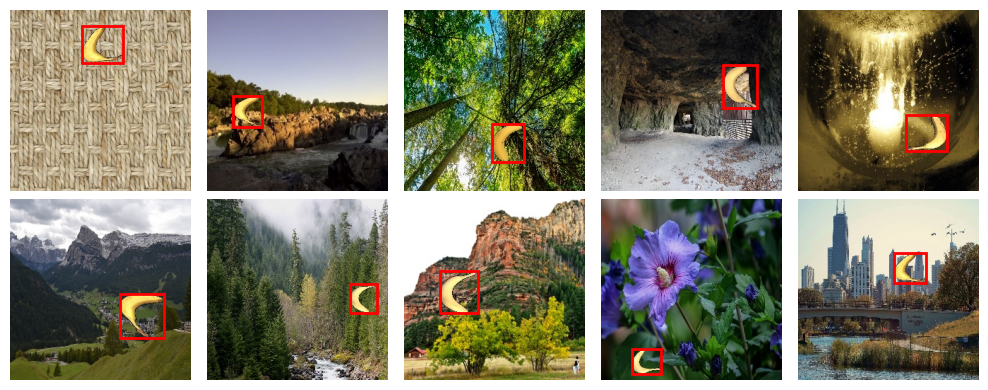

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 复制图像以便在上面绘制
display_imgs = (batch[0][0:10].permute(0, 2, 3, 1)).clone().numpy() / 255

# 创建图像显示
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()

for i, (ax, img, label) in enumerate(zip(axes, display_imgs, batch[1][0:10])):
    coords = label[0][1:5]
    print(f"Image {i} - Bounding box coordinates:", coords)
    
    # 显示图像
    ax.imshow(img)
    ax.axis('off')
    
    # 获取图像尺寸
    h, w = img.shape[:2]
    
    # 转换归一化坐标到像素坐标
    x_min, y_min, x_max, y_max = coords[0] * w, coords[1] * h, coords[2] * w, coords[3] * h
    
    # 绘制矩形框
    rect = Rectangle(
        xy=(x_min, y_min), 
        width=x_max - x_min, 
        height=y_max - y_min,
        fill=False, 
        edgecolor='red',
        linewidth=2
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

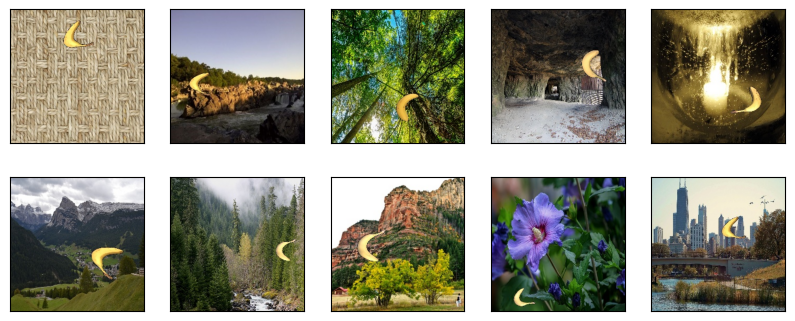

In [34]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## 小结

* 我们收集的香蕉检测数据集可用于演示目标检测模型。
* 用于目标检测的数据加载与图像分类的数据加载类似。但是，在目标检测中，标签还包含真实边界框的信息，它不出现在图像分类中。

## 练习

1. 在香蕉检测数据集中演示其他带有真实边界框的图像。它们在边界框和目标方面有什么不同？
1. 假设我们想要将数据增强（例如随机裁剪）应用于目标检测。它与图像分类中的有什么不同？提示：如果裁剪的图像只包含物体的一小部分会怎样？


[Discussions](https://discuss.d2l.ai/t/3202)
